In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv(
    "data/USO.csv", 
    parse_dates = ["Date"]
)

data.sort_values(by="Date", inplace=True)
data.set_index("Date", inplace=True)
data.head()

,USO
Date,
2007-01-03,-0.042636
2007-01-04,-0.040688
2007-01-05,0.009285
2007-01-08,-0.007109
2007-01-09,-0.004001


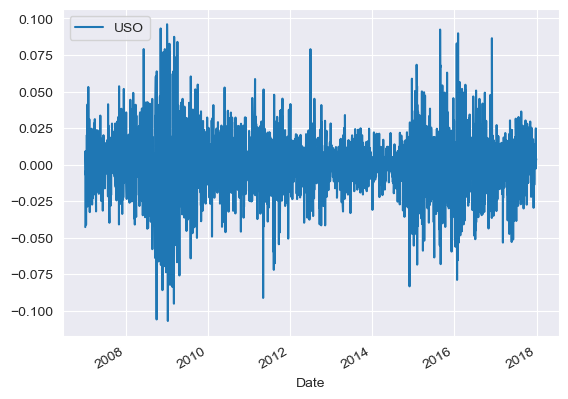

In [3]:
data.plot();

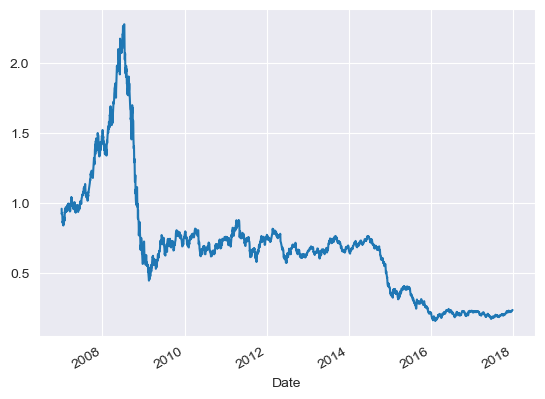

In [4]:
data["cum_prod"] = data.add(1).cumprod()
data.cum_prod.plot();

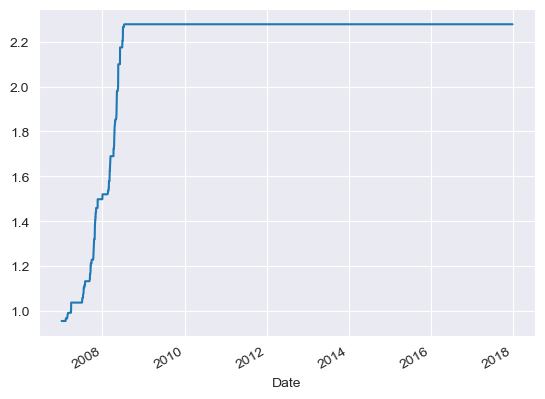

In [7]:
running_max = np.maximum.accumulate(data.cum_prod)
running_max.plot();

Text(0.5, 1.0, 'Drawdown')

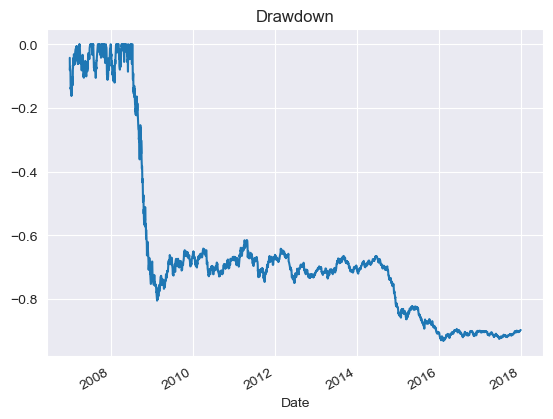

In [8]:
# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (data.cum_prod)/running_max - 1

# Plot the results
drawdown.plot()
plt.title("Drawdown")

# VAR

-0.03608233764037496


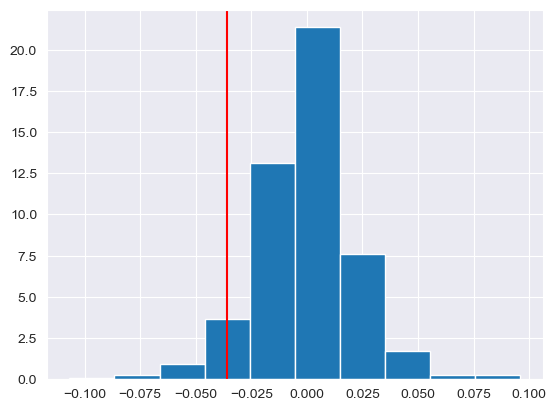

In [9]:
# Calculate historical VaR(95)
var_95 = np.percentile(data.USO, 5)
print(var_95)

# Sort the returns for plotting
sorted_rets = data["USO"].sort_values()

# Plot the probability of each sorted return quantile
plt.hist(sorted_rets, density=True, stacked=True)

# Denote the VaR 95 quantile
plt.axvline(
    x=var_95, 
    color='r', 
    linestyle='-', 
    label="VaR 95: {0:.2f}%".format(var_95)
);

# Historical expected shortfall

Expected Shortfall, otherwise known as CVaR, or conditional value at risk, is simply the expected loss of the worst case scenarios of returns.

For example, if your portfolio has a VaR(95) of -3%, then the CVaR(95) would be the average value of all losses exceeding -3%.



-0.05054143158346778


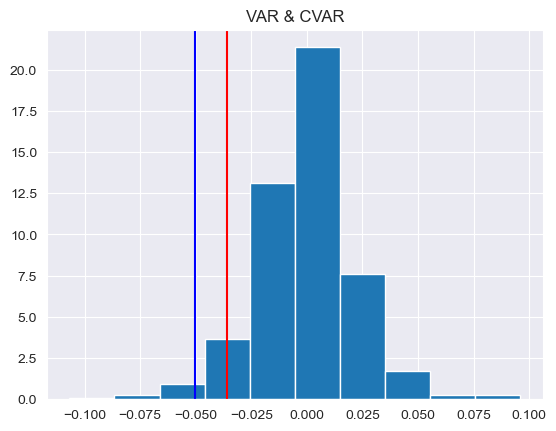

In [17]:
# Historical CVaR 95
cvar_95 = data.USO[data.USO < var_95].mean()
print(cvar_95)

# Sort the returns for plotting
sorted_rets = sorted(data.USO)

# Plot the probability of each return quantile
plt.hist(sorted_rets, density=True, stacked=True)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_95, color="r", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.title("VAR & CVAR");

# VaR extensions

## Changing VaR and CVaR quantiles



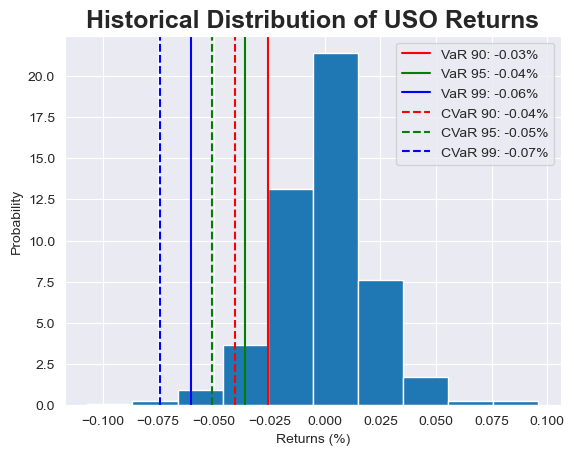

In [20]:
# Historical VaR(90) quantiles
def  calculate_var_cvar(input_data, input_percentile):
    output_var = np.percentile(input_data, input_percentile)

    output_cvar = input_data[input_data < output_var].mean()
    return output_var, output_cvar

var_90, cvar_90 = calculate_var_cvar(
    input_data = data.USO, 
    input_percentile = 10
)

var_95, cvar_95 = calculate_var_cvar(
    input_data = data.USO, 
    input_percentile = 5
)

var_99, cvar_99 = calculate_var_cvar(
    input_data = data.USO, 
    input_percentile = 1
)
# Plot to compare
plt.hist(sorted_rets, density=True, stacked=True)
# Charting parameters
plt.xlabel('Returns (%)')
plt.ylabel('Probability')
plt.title('Historical Distribution of USO Returns', fontsize=18, fontweight='bold')
plt.axvline(x=var_90, color='r', linestyle='-', label="VaR 90: {0:.2f}%".format(var_90))
plt.axvline(x=var_95, color='g', linestyle='-', label="VaR 95: {0:.2f}%".format(var_95))
plt.axvline(x=var_99, color='b', linestyle='-', label="VaR 99: {0:.2f}%".format(var_99))
plt.axvline(x=cvar_90, color='r', linestyle='--', label="CVaR 90: {0:.2f}%".format(cvar_90))
plt.axvline(x=cvar_95, color='g', linestyle='--', label="CVaR 95: {0:.2f}%".format(cvar_95))
plt.axvline(x=cvar_99, color='b', linestyle='--', label="CVaR 99: {0:.2f}%".format(cvar_99))
plt.legend(loc='upper right')
#plt.show()

In [21]:
# Import norm from scipy.stats
from scipy.stats import norm

# Estimate the average daily return
mu = np.mean(data.USO)

# Estimate the daily volatility
vol = np.std(data.USO)

# Set the VaR confidence level
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(
    confidence_level, 
    mu, 
    vol
)

print('Mean: ', str(mu), '\nVolatility: ', str(vol), '\nVaR(95): ', str(var_95))

Mean:  -0.00028638956240214787 
Volatility:  0.021888087129708873 
VaR(95):  -0.036289089064733646


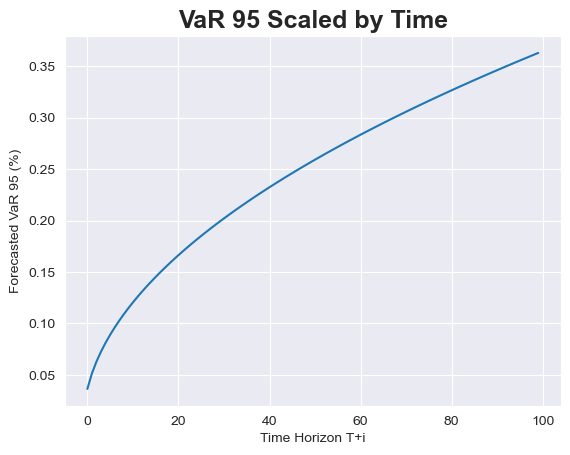

In [24]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(0, 100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    # Save the forecasted VaR 95
    forecasted_values[i, 1] = var_95 * np.sqrt(i + 1)
    
# Plot the forecased vs time
plt.plot(forecasted_values[:,0], -1*forecasted_values[:,1])
plt.xlabel('Time Horizon T+i')
plt.ylabel('Forecasted VaR 95 (%)')
plt.title('VaR 95 Scaled by Time', fontsize=18, fontweight='bold');

# Random walks


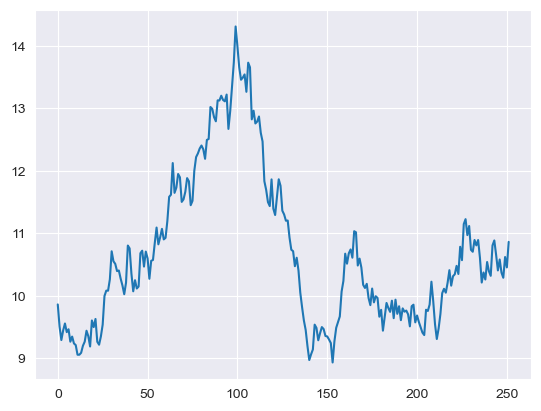

In [25]:
# Set the simulation parameters
mu = np.mean(data.USO)
vol = np.std(data.USO)
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu, vol, T) + 1

# Forecasted random walk
forecasted_values = S0 * rand_rets.cumprod()

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.show()

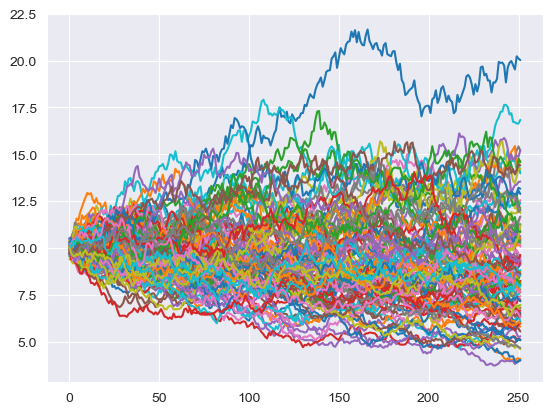

In [26]:
# Loop through 100 simulations
for i in range(0, 100):

    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_values)

# Show the simulations
plt.show()

In [27]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):

    # Generate the Random Walk
    rand_rets = np.random.normal(mu, vol, T)
    
    # Save the results
    sim_returns.append(rand_rets)

# Calculate the VaR(99)
var_99 = np.percentile(sim_returns, 1)
print("Parametric VaR(99): ", round(100*var_99, 2),"%")

Parametric VaR(99):  -5.05 %
